# Climate Legal Readiness Index (CLRI)

This notebook details the entire quantitative analysis for the project. We load, clean, and merge 5 different datasets related to governance, law, and climate to create a final "Climate Legal Readiness Index."

### Table of Contents
1.  [Setup & Data Loading](#1-setup--data-loading)
    * [1.1. Worldwide Governance Indicators (WGI)](#11-worldwide-governance-indicators-wgi)
    * [1.2. Quality of Government (QoG)](#12-quality-of-government-qog)
    * [1.3. ND-GAIN Country Index](#13-nd-gain-country-index)
    * [1.4. Climate Change Knowledge Portal (CCKP)](#14-climate-change-knowledge-portal-cckp)
    * [1.5. Merging All Datasets](#15-merging-all-datasets)
    * [1.6. Final Cleaning & Imputation](#16-final-cleaning--imputation)
2.  [Exploratory Data Analysis (EDA)](#2-exploratory-data-analysis-eda)
3.  [Modeling & Index Creation](#3-modeling--index-creation)
    * [3.1. Feature Scaling (StandardScaler)](#31-feature-scaling)
    * [3.2. Principal Component Analysis (PCA)](#32-principal-component-analysis-pca)
    * [3.3. K-Means Clustering](#33-k-means-clustering)
4.  [Final Index Construction](#4-final-index-construction)
    * [4.1. Method 1: Equal-Weight Index (Z-Score)](#41-method-1-equal-weight-index-z-score)
    * [4.2. Method 2: PCA-Weighted Index (Validation)](#42-method-2-pca-weighted-index-validation)
5.  [Final Visualization & Export](#5-final-visualization--export)

The main steps are:
1.  **Setup & Load:** Import libraries and load all 5 raw datasets.
2.  **Clean & Merge:** Clean each dataset, select features, and merge into a master file.
3.  **Model:** Apply StandardScaler, PCA (for analysis), and K-Means (for grouping).
4.  **Index Creation:** Construct the final CLRI and validate it.
5.  **Visualize:** Plot the final index on a global map.

In [ ]:
# pip install pandas numpy plotly fuzzywuzzy python-Levenshtein country_converter openpyxl


In [2]:
import os
import pandas as pd
import numpy as np
import country_converter as coco
from fuzzywuzzy import process

BASE = r"E:\PROJECTS\climate_legal_readiness_project"
RAW  = os.path.join(BASE, "data", "raw")
PROC = os.path.join(BASE, "data", "processed")

os.makedirs(PROC, exist_ok=True)
cc = coco.CountryConverter()

def standardize_country(series):
    iso3 = cc.convert(series.tolist(), to='ISO3', not_found=None)
    names = cc.convert(iso3, to='name_short', not_found=None)
    return pd.Series(names, index=series.index)

## 1: Setup & Data Loading
<a id='1-setup--data-loading'></a>
We will load each of the 5 datasets one by one, clean them, and prepare them for merging.

In [5]:
wgi = pd.read_csv(os.path.join(RAW, "WGI_Data_2015_2023.csv"))
qog = pd.read_csv(os.path.join(RAW, "qog_std_cs_jan25.csv"))
ndgain = pd.read_csv(os.path.join(RAW, "ND_GAIN_CountryIndex.csv"))
cckp = pd.read_excel(os.path.join(RAW, "cru-x0.5_climatology_tasmax,tas,pr_climatology_annual_1991-2020_mean_historical_cru_ts4.08_mean.xlsx"))
wjp = pd.read_excel(os.path.join(RAW, "WJP_RuleOfLaw.xlsx"))

### 1.1. Worldwide Governance Indicators (WGI)
<a id='11-worldwide-governance-indicators-wgi'></a>
* **Source:** `WGI_Data_2015_2023.csv`
* **Action:** Load the data, select the most recent year's "Estimate" for our 6 key indicators, and pivot the table from a long format (one row per indicator) to a wide format (one column per indicator).

In [8]:
import pandas as pd
import os

wgi_path = r"E:\PROJECTS\climate_legal_readiness_project\data\raw\WGI_Data_2015_2023.csv"
wgi = pd.read_csv(wgi_path)


keep_cols = ['Country Name', 'Series Name', 'Series Code'] + [c for c in wgi.columns if '[YR' in c]
wgi = wgi[keep_cols]

wgi_long = wgi.melt(
    id_vars=['Country Name', 'Series Name', 'Series Code'],
    var_name='Year',
    value_name='Estimate'
)

wgi_long['Year'] = wgi_long['Year'].str.extract(r'(\d{4})').astype(int)

latest_year = wgi_long['Year'].max()
wgi_latest = wgi_long[wgi_long['Year'] == latest_year].copy()

print("Latest year found:", latest_year)
print("Shape after filtering:", wgi_latest.shape)
print(wgi_latest.head(5))

Latest year found: 2023
Shape after filtering: (1289, 5)
      Country Name                                        Series Name  \
10312  Afghanistan                    Control of Corruption: Estimate   
10313  Afghanistan                 Government Effectiveness: Estimate   
10314  Afghanistan  Political Stability and Absence of Violence/Te...   
10315  Afghanistan                       Regulatory Quality: Estimate   
10316  Afghanistan                              Rule of Law: Estimate   

      Series Code  Year           Estimate  
10312      CC.EST  2023  -1.15493178367615  
10313      GE.EST  2023  -1.98701369762421  
10314      PV.EST  2023  -2.48408055305481  
10315      RQ.EST  2023  -1.26642525196075  
10316      RL.EST  2023  -1.64964091777802  


In [9]:
keep_inds = [
    'Control of Corruption: Estimate',
    'Government Effectiveness: Estimate',
    'Political Stability and Absence of Violence/Terrorism: Estimate',
    'Regulatory Quality: Estimate',
    'Rule of Law: Estimate',
    'Voice and Accountability: Estimate'
]

wgi_filtered = wgi_latest[wgi_latest['Series Name'].isin(keep_inds)].copy()

rename_map = {
    'Control of Corruption: Estimate': 'wgi_corruption',
    'Government Effectiveness: Estimate': 'wgi_gov_effect',
    'Political Stability and Absence of Violence/Terrorism: Estimate': 'wgi_stability',
    'Regulatory Quality: Estimate': 'wgi_reg_quality',
    'Rule of Law: Estimate': 'wgi_rule_of_law',
    'Voice and Accountability: Estimate': 'wgi_voice'
}

wgi_pivot = (
    wgi_filtered.replace({'Series Name': rename_map})
    .pivot_table(index='Country Name', columns='Series Name', values='Estimate', aggfunc='first')
    .reset_index()
)

wgi_pivot.columns.name = None
wgi_pivot.rename(columns={'Country Name': 'country_raw'}, inplace=True)

print("Shape:", wgi_pivot.shape)
wgi_pivot.head(10)

Shape: (214, 7)


country_raw      wgi_corruption      wgi_gov_effect  \
0          Afghanistan   -1.15493178367615   -1.98701369762421   
1              Albania  -0.332218527793884   0.250855356454849   
2              Algeria  -0.589308321475983  -0.670135140419006   
3       American Samoa    1.25135612487793   0.654167771339417   
4              Andorra    1.25135612487793     1.4754387140274   
5               Angola   -0.60992020368576   -1.00890958309174   
6             Anguilla    1.25135612487793    1.20168173313141   
7  Antigua and Barbuda   0.326792687177658   0.380410820245743   
8            Argentina  -0.360883951187134  -0.377517342567444   
9              Armenia  0.0583996474742889  -0.184129968285561   

      wgi_reg_quality     wgi_rule_of_law       wgi_stability  \
0   -1.26642525196075   -1.64964091777802   -2.48408055305481   
1   0.171953663229942  -0.164097368717194   0.183348968625069   
2  -0.948087155818939  -0.678364396095276  -0.577885270118713   
3   0.512013554573059    1.21249115467072    1.11422121524811   
4    1.35054576396942    1.47689890861511    1.58346593379974   
5  -0.761388182640076   -1.09906601905823   -0.34150505065918   
6   0.931279718875885   0.683675646781921    1.11422121524811   
7   0.546036779880524   0.378593176603317   0.923393249511719   
8  -0.482535392045975  -0.410826534032822  -0.127517908811569   
9   0.047635018825531  -0.122017979621887  -0.829278230667114   

            wgi_voice  
0   -1.85290133953094  
1   0.168997228145599  
2  -0.979883790016174  
3                  ..  
4   0.996939778327942  
5  -0.737252414226532  
6                  ..  
7   0.741840481758118  
8   0.533921837806702  
9  0.0767075568437576

### 1.2. Quality of Government (QoG)
<a id='12-quality-of-government-qog'></a>
* **Source:** `qog_std_cs_jan25.csv`
* **Action:** Load the standard cross-sectional dataset. This is a very large file with over 2,000 features. We will select only a few features most relevant to governance, bureaucratic quality, and environmental policy, then rename them for clarity.

In [10]:
import pandas as pd
import os

qog_path = r"E:\PROJECTS\climate_legal_readiness_project\data\raw\qog_std_cs_jan25.csv"

qog = pd.read_csv(qog_path, low_memory=False)
print("Shape:", qog.shape)
print("\nFirst 10 columns:\n", list(qog.columns)[:10])
qog.head(5)

Shape: (194, 1641)

First 10 columns:
 ['cname_qog', 'cname', 'ccode_qog', 'ccodecow', 'ccodealp', 'ccode', 'aii_acc', 'aii_aio', 'aii_cilser', 'aii_elec']


cname_qog        cname  ccode_qog  ccodecow ccodealp  ccode  aii_acc  \
0  Afghanistan  Afghanistan          4     700.0      AFG    4.0      NaN   
1      Albania      Albania          8     339.0      ALB    8.0      NaN   
2      Algeria      Algeria         12     615.0      DZA   12.0    12.50   
3      Andorra      Andorra         20     232.0      AND   20.0      NaN   
4       Angola       Angola         24     540.0      AGO   24.0    18.75   

   aii_aio  aii_cilser  aii_elec  ...  yri_fem40  yri_fem4160  yri_fem61  \
0      NaN         NaN       NaN  ...        NaN          NaN        NaN   
1      NaN         NaN       NaN  ...       20.8         75.0        4.2   
2      5.0        12.5  8.333333  ...        NaN          NaN        NaN   
3      NaN         NaN       NaN  ...        7.1         78.6       14.3   
4     15.0         0.0  0.000000  ...        NaN          NaN        NaN   

   yri_meanage  yri_medianage  yri_mp30  yri_mp35  yri_mp40  yri_mp4160  \
0          NaN            NaN       NaN       NaN       NaN         NaN   
1         51.0           51.0       0.0       5.8      15.9        72.5   
2          NaN            NaN       NaN       NaN       NaN         NaN   
3         48.2           48.5       3.6      14.3      17.9        71.4   
4          NaN            NaN       NaN       NaN       NaN         NaN   

   yri_mp61  
0       NaN  
1      11.6  
2       NaN  
3      10.7  
4       NaN  

[5 rows x 1641 columns]

In [12]:
import re

search_terms = ['law', 'gov', 'env', 'clim', 'corrupt']
for term in search_terms:
    matches = [c for c in qog.columns if re.search(term, c, re.IGNORECASE)]
    print(f"\n--- Columns containing '{term}' ({len(matches)} found) ---")
    print(matches[:20]) 


--- Columns containing 'law' (1 found) ---
['wdi_wombuslawi']

--- Columns containing 'gov' (37 found) ---
['cpds_govlr', 'cpds_govsup', 'egov_egov', 'egov_epar', 'egov_hci', 'egov_osi', 'egov_tii', 'eu_resgovf', 'eu_resgovt', 'gain_gov', 'iiag_gov', 'oecd_govdefct_t1', 'oecd_govdefct_t2', 'wdi_dgovhexp', 'wgov_leadexp', 'wgov_min', 'wgov_minage', 'wgov_minfem', 'wgov_minmil', 'wgov_minten']

--- Columns containing 'env' (4 found) ---
['eu_envnc', 'gfs_envr', 'sgi_envs24', 'wvs_confenv']

--- Columns containing 'clim' (0 found) ---
[]

--- Columns containing 'corrupt' (0 found) ---
[]


In [13]:
import pandas as pd
import country_converter as coco

cc = coco.CountryConverter()

keep_cols = [
    'cname',         
    'gain_gov',      
    'egov_egov',    
    'iiag_gov',      
    'eu_envnc',      
    'wvs_confenv',  
    'wdi_wombuslawi' 
]

present = [c for c in keep_cols if c in qog.columns]
print("Columns found:", present)

qog_small = qog[present].copy()

rename_map = {
    'cname': 'country_raw',
    'gain_gov': 'qog_gov_readiness',
    'egov_egov': 'qog_e_gov_index',
    'iiag_gov': 'qog_gov_score',
    'eu_envnc': 'qog_env_context',
    'wvs_confenv': 'qog_env_confidence',
    'wdi_wombuslawi': 'qog_women_business_law'
}
qog_small.rename(columns=rename_map, inplace=True)

qog_small['country'] = cc.convert(qog_small['country_raw'].tolist(), to='name_short', not_found=None)
qog_small = qog_small.drop(columns=['country_raw']).drop_duplicates(subset=['country'])

print("Shape after cleaning:", qog_small.shape)
qog_small.head(10)

Congo (the) not found in regex


Columns found: ['cname', 'gain_gov', 'egov_egov', 'iiag_gov', 'eu_envnc', 'wvs_confenv', 'wdi_wombuslawi']
Shape after cleaning: (194, 7)


qog_gov_readiness  qog_e_gov_index  qog_gov_score  qog_env_context  \
0           0.170507           0.2710            NaN              NaN   
1           0.472414           0.7413            NaN             26.5   
2           0.323543           0.5611           56.2              NaN   
3                NaN           0.7177            NaN              NaN   
4           0.352678           0.3789           42.8              NaN   
5           0.589801           0.6113            NaN              NaN   
6           0.384430           0.6937            NaN              NaN   
7           0.423251           0.8198            NaN              NaN   
8           0.807463           0.9405            NaN              NaN   
9           0.764762           0.8801            NaN              0.0   

   qog_env_confidence  qog_women_business_law              country  
0                 NaN                  38.125          Afghanistan  
1            2.074515                  91.250              Albania  
2                 NaN                  57.500              Algeria  
3            2.720322                     NaN              Andorra  
4                 NaN                  79.375               Angola  
5                 NaN                  66.250  Antigua and Barbuda  
6            2.534603                  78.750           Azerbaijan  
7                 NaN                  79.375            Argentina  
8            2.595490                  96.875            Australia  
9            2.696127                  96.875              Austria

### 1.3. ND-GAIN Country Index
<a id='13-nd-gain-country-index'></a>
* **Source:** `ND_GAIN_CountryIndex.csv`
* **Action:** Load the Notre Dame Global Adaptation Initiative data. We will select the overall readiness and vulnerability scores, which are key components of our final index.

In [17]:
import pandas as pd
import country_converter as coco
import os

cc = coco.CountryConverter()

nd_path = r"E:\PROJECTS\climate_legal_readiness_project\data\raw\ND_GAIN_CountryIndex.csv"
ndgain = pd.read_csv(nd_path)

print("Shape:", ndgain.shape)
print("First 10 columns:", list(ndgain.columns)[:10])
ndgain.head(3)

Shape: (192, 31)
First 10 columns: ['ISO3', 'Name', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002']


ISO3         Name       1995       1996       1997       1998       1999  \
0  AFG  Afghanistan  34.783530  34.775074  34.988812  35.293407  35.177507   
1  ALB      Albania  41.396494  41.379214  41.333451  41.100159  41.026585   
2  DZA      Algeria  45.208524  45.310608  44.711577  44.217693  44.233838   

        2000       2001       2002  ...       2014       2015       2016  \
0  35.065559  35.198269  35.335123  ...  31.544162  31.795961  31.903926   
1  41.381430  41.395906  41.602467  ...  46.435235  47.225916  47.113945   
2  44.198576  44.255934  44.295123  ...  44.982398  45.123443  45.471441   

        2017       2018       2019       2020       2021       2022       2023  
0  31.346547  31.165179  31.910511  31.727814  32.833517  32.633596  32.765017  
1  47.064079  47.340870  47.412095  47.738609  48.443320  49.348682  49.747451  
2  46.624614  46.353467  46.487537  47.531633  47.246477  47.391899  47.689392  

[3 rows x 31 columns]

In [18]:
dgain_long = ndgain.melt(
    id_vars=['ISO3', 'Name'],
    var_name='year',
    value_name='ndgain_overall'
)

ndgain_long['year'] = ndgain_long['year'].astype(int)

latest_year = ndgain_long['year'].max()
ndgain_latest = ndgain_long[ndgain_long['year'] == latest_year].copy()

ndgain_latest.rename(columns={'Name': 'country_raw'}, inplace=True)
ndgain_latest['country'] = coco.CountryConverter().convert(ndgain_latest['country_raw'], to='name_short', not_found=None)

ndgain_latest = ndgain_latest[['country', 'ndgain_overall']].drop_duplicates(subset=['country'])

print("Latest year:", latest_year)
print("Shape after cleaning:", ndgain_latest.shape)
ndgain_latest.head(10)

Latest year: 2023
Shape after cleaning: (192, 2)


country  ndgain_overall
5376          Afghanistan       32.765017
5377              Albania       49.747451
5378              Algeria       47.689392
5379              Andorra             NaN
5380               Angola       37.043357
5381  Antigua and Barbuda       47.278459
5382            Argentina       48.090403
5383              Armenia       56.714012
5384            Australia       69.197042
5385              Austria       67.943328

#### ND-GAIN (Continued) - Merging Detailed Scores
The main `ND_GAIN_CountryIndex.csv` file provides the overall score. Now, we will load the two detailed time-series files, `gain_readiness.csv` and `gain_vulnerability.csv`.

* **Action:** We'll load both files, melt them from wide-to-long, extract the latest year's data for each, and then merge these detailed scores with our main `ndgain_latest` DataFrame.
* **Output:** This creates a new `ndgain_full` DataFrame that combines the main score with the specific, latest readiness and vulnerability scores.

In [20]:
base_path = r"E:\PROJECTS\climate_legal_readiness_project\data\raw"

readiness = pd.read_csv(os.path.join(base_path, "gain_readiness.csv"))
vulnerability = pd.read_csv(os.path.join(base_path, "gain_vulnerability.csv"))

readiness_long = readiness.melt(id_vars=['ISO3', 'Name'], var_name='year', value_name='ndgain_readiness')
readiness_long['year'] = readiness_long['year'].astype(int)
readiness_latest = readiness_long[readiness_long['year'] == readiness_long['year'].max()].copy()
readiness_latest.rename(columns={'Name': 'country_raw'}, inplace=True)
readiness_latest['country'] = coco.CountryConverter().convert(readiness_latest['country_raw'], to='name_short', not_found=None)
readiness_latest = readiness_latest[['country', 'ndgain_readiness']].drop_duplicates(subset=['country'])

vulnerability_long = vulnerability.melt(id_vars=['ISO3', 'Name'], var_name='year', value_name='ndgain_vulnerability')
vulnerability_long['year'] = vulnerability_long['year'].astype(int)
vulnerability_latest = vulnerability_long[vulnerability_long['year'] == vulnerability_long['year'].max()].copy()
vulnerability_latest.rename(columns={'Name': 'country_raw'}, inplace=True)
vulnerability_latest['country'] = coco.CountryConverter().convert(vulnerability_latest['country_raw'], to='name_short', not_found=None)
vulnerability_latest = vulnerability_latest[['country', 'ndgain_vulnerability']].drop_duplicates(subset=['country'])

ndgain_full = (
    ndgain_latest
    .merge(readiness_latest, on='country', how='left')
    .merge(vulnerability_latest, on='country', how='left')
)

print("Shape after combining all ND-GAIN components:", ndgain_full.shape)
ndgain_full.head(10)

Shape after combining all ND-GAIN components: (192, 4)


country  ndgain_overall  ndgain_readiness  ndgain_vulnerability
0          Afghanistan       32.765017          0.242817              0.587516
1              Albania       49.747451          0.375133              0.380184
2              Algeria       47.689392          0.321140              0.367352
3              Andorra             NaN          0.452459                   NaN
4               Angola       37.043357          0.247241              0.506373
5  Antigua and Barbuda       47.278459          0.413251              0.467682
6            Argentina       48.090403          0.345166              0.383358
7              Armenia       56.714012          0.491592              0.357312
8            Australia       69.197042          0.699878              0.315937
9              Austria       67.943328          0.654183              0.295317

### 1.4. Climate Change Knowledge Portal (CCKP)
<a id='14-climate-change-knowledge-portal-cckp'></a>
* **Source:** `cru-x0.5_climatology...`
* **Action:** Load the World Bank's historical climate data. We are selecting the 1991-2020 mean annual precipitation (`clim_pr_mean`) as a proxy for a country's baseline climate profile.

In [21]:
import pandas as pd
import country_converter as coco

cc = coco.CountryConverter()

cckp_path = r"E:\PROJECTS\climate_legal_readiness_project\data\raw\cru-x0.5_climatology_tasmax,tas,pr_climatology_annual_1991-2020_mean_historical_cru_ts4.08_mean.xlsx"
cckp = pd.read_excel(cckp_path)

print("Shape:", cckp.shape)
print("First 10 columns:", list(cckp.columns)[:10])
cckp.head(5)

Shape: (246, 3)
First 10 columns: ['code', 'name', '1991-07']


code             name  1991-07
0  ABW    Aruba (Neth.)   432.93
1  AFG      Afghanistan   336.61
2  AGO           Angola  1043.87
3  AIA  Anguilla (U.K.)  1050.53
4  ALA              ALA   515.12

In [23]:
import pandas as pd
import country_converter as coco

cc = coco.CountryConverter()
clim = pd.read_excel(cckp_path)
clim.columns = clim.columns.str.strip().str.lower()

clim.rename(columns={
    'code': 'iso3',
    'name': 'country_raw',
    '1991-07': 'clim_pr_mean'  
}, inplace=True)

clim['country'] = cc.convert(clim['country_raw'].tolist(), to='name_short', not_found=None)

clim = clim[['country', 'clim_pr_mean']].drop_duplicates(subset=['country'])

print("Shape after cleaning:", clim.shape)
clim.head(10)

Shape after cleaning: (245, 2)


country  clim_pr_mean
0                 Aruba        432.93
1           Afghanistan        336.61
2                Angola       1043.87
3              Anguilla       1050.53
4         Åland Islands        515.12
5               Albania       1120.21
6               Andorra       1043.31
7  United Arab Emirates         59.44
8             Argentina        616.20
9               Armenia        551.62

### 1.5. Merging All Datasets
<a id='15-merging-all-datasets'></a>
Now that all individual datasets are cleaned and standardized with a `country` column, we will merge them into a single master DataFrame. We will use an **inner merge** to ensure we only keep countries that have data across all our key sources.

First, we standardize the country names in our base `wgi_pivot` table.

In [26]:
import country_converter as coco

cc = coco.CountryConverter()

wgi_pivot['country'] = cc.convert(wgi_pivot['country_raw'].tolist(), to='name_short', not_found=None)

wgi_pivot.drop(columns=['country_raw'], inplace=True)

print(wgi_pivot.head(3))
print("\nColumns now:", wgi_pivot.columns.tolist())

Netherlands Antilles not found in regex


       wgi_corruption      wgi_gov_effect     wgi_reg_quality  \
0   -1.15493178367615   -1.98701369762421   -1.26642525196075   
1  -0.332218527793884   0.250855356454849   0.171953663229942   
2  -0.589308321475983  -0.670135140419006  -0.948087155818939   

      wgi_rule_of_law       wgi_stability           wgi_voice      country  
0   -1.64964091777802   -2.48408055305481   -1.85290133953094  Afghanistan  
1  -0.164097368717194   0.183348968625069   0.168997228145599      Albania  
2  -0.678364396095276  -0.577885270118713  -0.979883790016174      Algeria  

Columns now: ['wgi_corruption', 'wgi_gov_effect', 'wgi_reg_quality', 'wgi_rule_of_law', 'wgi_stability', 'wgi_voice', 'country']


Now we define a helper function `merge_data` and merge all DataFrames with our `wgi_pivot` base table.

In [27]:
import os
import pandas as pd

df = wgi_pivot.copy()

def merge_data(df_left, df_right, name):
    before = df_left.shape[0]
    df_merged = df_left.merge(df_right, on='country', how='inner')
    after = df_merged.shape[0]
    print(f"Merged {name}: {before} → {after} rows")
    return df_merged

df = merge_data(df, qog_small, "QoG")
df = merge_data(df, ndgain_full, "ND-GAIN")
df = merge_data(df, clim, "CCKP Climate")

print("\nFinal merged dataset shape:", df.shape)
df.head(10)

Merged QoG: 214 → 193 rows
Merged ND-GAIN: 193 → 191 rows
Merged CCKP Climate: 191 → 190 rows

Final merged dataset shape: (190, 17)


wgi_corruption      wgi_gov_effect     wgi_reg_quality  \
0   -1.15493178367615   -1.98701369762421   -1.26642525196075   
1  -0.332218527793884   0.250855356454849   0.171953663229942   
2  -0.589308321475983  -0.670135140419006  -0.948087155818939   
3    1.25135612487793     1.4754387140274    1.35054576396942   
4   -0.60992020368576   -1.00890958309174  -0.761388182640076   
5   0.326792687177658   0.380410820245743   0.546036779880524   
6  -0.360883951187134  -0.377517342567444  -0.482535392045975   
7  0.0583996474742889  -0.184129968285561   0.047635018825531   
8    1.78120493888855    1.58987963199615    1.94220554828644   
9     1.1336532831192    1.32668149471283    1.36136972904205   

      wgi_rule_of_law       wgi_stability           wgi_voice  \
0   -1.64964091777802   -2.48408055305481   -1.85290133953094   
1  -0.164097368717194   0.183348968625069   0.168997228145599   
2  -0.678364396095276  -0.577885270118713  -0.979883790016174   
3    1.47689890861511    1.58346593379974   0.996939778327942   
4   -1.09906601905823   -0.34150505065918  -0.737252414226532   
5   0.378593176603317   0.923393249511719   0.741840481758118   
6  -0.410826534032822  -0.127517908811569   0.533921837806702   
7  -0.122017979621887  -0.829278230667114  0.0767075568437576   
8    1.52318394184113    0.91705721616745    1.50660192966461   
9    1.74656546115875   0.727989196777344    1.41124832630157   

               country  qog_gov_readiness  qog_e_gov_index  qog_gov_score  \
0          Afghanistan           0.170507           0.2710            NaN   
1              Albania           0.472414           0.7413            NaN   
2              Algeria           0.323543           0.5611           56.2   
3              Andorra                NaN           0.7177            NaN   
4               Angola           0.352678           0.3789           42.8   
5  Antigua and Barbuda           0.589801           0.6113            NaN   
6            Argentina           0.423251           0.8198            NaN   
7              Armenia           0.471085           0.7364            NaN   
8            Australia           0.807463           0.9405            NaN   
9              Austria           0.764762           0.8801            NaN   

   qog_env_context  qog_env_confidence  qog_women_business_law  \
0              NaN                 NaN                  38.125   
1             26.5            2.074515                  91.250   
2              NaN                 NaN                  57.500   
3              NaN            2.720322                     NaN   
4              NaN                 NaN                  79.375   
5              NaN                 NaN                  66.250   
6              NaN                 NaN                  79.375   
7              NaN            2.305046                  87.500   
8              NaN            2.595490                  96.875   
9              0.0            2.696127                  96.875   

   ndgain_overall  ndgain_readiness  ndgain_vulnerability  clim_pr_mean  
0       32.765017          0.242817              0.587516        336.61  
1       49.747451          0.375133              0.380184       1120.21  
2       47.689392          0.321140              0.367352         84.22  
3             NaN          0.452459                   NaN       1043.31  
4       37.043357          0.247241              0.506373       1043.87  
5       47.278459          0.413251              0.467682       1066.36  
6       48.090403          0.345166              0.383358        616.20  
7       56.714012          0.491592              0.357312        551.62  
8       69.197042          0.699878              0.315937        483.38  
9       67.943328          0.654183              0.295317       1121.02

### 1.6. Final Cleaning & Imputation
<a id='16-final-cleaning--imputation'></a>
We'll perform a quick sanity check to see how many missing values resulted from our merges.

In [28]:
print("Total countries:", df.shape[0])
print("\nMissing values per column:")
print(df.isna().sum())

print("\nPreview:")
df.head(10)

Total countries: 190

Missing values per column:
wgi_corruption              0
wgi_gov_effect              0
wgi_reg_quality             0
wgi_rule_of_law             0
wgi_stability               0
wgi_voice                   0
country                     0
qog_gov_readiness           5
qog_e_gov_index             1
qog_gov_score             139
qog_env_context           158
qog_env_confidence        119
qog_women_business_law      8
ndgain_overall              5
ndgain_readiness            0
ndgain_vulnerability        5
clim_pr_mean                0
dtype: int64

Preview:


wgi_corruption      wgi_gov_effect     wgi_reg_quality  \
0   -1.15493178367615   -1.98701369762421   -1.26642525196075   
1  -0.332218527793884   0.250855356454849   0.171953663229942   
2  -0.589308321475983  -0.670135140419006  -0.948087155818939   
3    1.25135612487793     1.4754387140274    1.35054576396942   
4   -0.60992020368576   -1.00890958309174  -0.761388182640076   
5   0.326792687177658   0.380410820245743   0.546036779880524   
6  -0.360883951187134  -0.377517342567444  -0.482535392045975   
7  0.0583996474742889  -0.184129968285561   0.047635018825531   
8    1.78120493888855    1.58987963199615    1.94220554828644   
9     1.1336532831192    1.32668149471283    1.36136972904205   

      wgi_rule_of_law       wgi_stability           wgi_voice  \
0   -1.64964091777802   -2.48408055305481   -1.85290133953094   
1  -0.164097368717194   0.183348968625069   0.168997228145599   
2  -0.678364396095276  -0.577885270118713  -0.979883790016174   
3    1.47689890861511    1.58346593379974   0.996939778327942   
4   -1.09906601905823   -0.34150505065918  -0.737252414226532   
5   0.378593176603317   0.923393249511719   0.741840481758118   
6  -0.410826534032822  -0.127517908811569   0.533921837806702   
7  -0.122017979621887  -0.829278230667114  0.0767075568437576   
8    1.52318394184113    0.91705721616745    1.50660192966461   
9    1.74656546115875   0.727989196777344    1.41124832630157   

               country  qog_gov_readiness  qog_e_gov_index  qog_gov_score  \
0          Afghanistan           0.170507           0.2710            NaN   
1              Albania           0.472414           0.7413            NaN   
2              Algeria           0.323543           0.5611           56.2   
3              Andorra                NaN           0.7177            NaN   
4               Angola           0.352678           0.3789           42.8   
5  Antigua and Barbuda           0.589801           0.6113            NaN   
6            Argentina           0.423251           0.8198            NaN   
7              Armenia           0.471085           0.7364            NaN   
8            Australia           0.807463           0.9405            NaN   
9              Austria           0.764762           0.8801            NaN   

   qog_env_context  qog_env_confidence  qog_women_business_law  \
0              NaN                 NaN                  38.125   
1             26.5            2.074515                  91.250   
2              NaN                 NaN                  57.500   
3              NaN            2.720322                     NaN   
4              NaN                 NaN                  79.375   
5              NaN                 NaN                  66.250   
6              NaN                 NaN                  79.375   
7              NaN            2.305046                  87.500   
8              NaN            2.595490                  96.875   
9              0.0            2.696127                  96.875   

   ndgain_overall  ndgain_readiness  ndgain_vulnerability  clim_pr_mean  
0       32.765017          0.242817              0.587516        336.61  
1       49.747451          0.375133              0.380184       1120.21  
2       47.689392          0.321140              0.367352         84.22  
3             NaN          0.452459                   NaN       1043.31  
4       37.043357          0.247241              0.506373       1043.87  
5       47.278459          0.413251              0.467682       1066.36  
6       48.090403          0.345166              0.383358        616.20  
7       56.714012          0.491592              0.357312        551.62  
8       69.197042          0.699878              0.315937        483.38  
9       67.943328          0.654183              0.295317       1121.02

Columns with excessive missing values (e.g., >50% missing) are dropped as they are unusable. For the remaining columns, we will fill any missing values using the column's mean. This is a simple imputation method suitable for this index.

In [30]:
threshold = 0.5 * len(df)
df = df.dropna(axis=1, thresh=threshold)

df = df.fillna(df.mean(numeric_only=True))

print("✅ After cleaning:")
print(df.isna().sum())
print("\nNew shape:", df.shape)

✅ After cleaning:
wgi_corruption            0
wgi_gov_effect            0
wgi_reg_quality           0
wgi_rule_of_law           0
wgi_stability             0
wgi_voice                 0
country                   0
qog_gov_readiness         0
qog_e_gov_index           0
qog_women_business_law    0
ndgain_overall            0
ndgain_readiness          0
ndgain_vulnerability      0
clim_pr_mean              0
dtype: int64

New shape: (190, 14)


Now we save our cleaned, merged, and imputed master dataset to a new CSV file in the `processed` folder.

In [31]:
import os

processed_path = r"E:\PROJECTS\climate_legal_readiness_project\data\processed\master_countries.csv"
df.to_csv(processed_path, index=False)
print("Saved master dataset at:", processed_path)

Saved master dataset at: E:\PROJECTS\climate_legal_readiness_project\data\processed\master_countries.csv


## 2: Exploratory Data Analysis (EDA)
<a id='2-exploratory-data-analysis-eda'></a>
With the master dataset saved, we will perform some initial analysis to understand the distributions and relationships between our features.

In [34]:
import pandas as pd

print("Shape:", df.shape)
print("\nSummary Statistics:")
display(df.describe().T)

Shape: (190, 14)

Summary Statistics:


count         mean         std        min         25%  \
qog_gov_readiness       190.0     0.492889    0.179600   0.078689    0.363620   
qog_e_gov_index         190.0     0.617625    0.208930   0.134000    0.449800   
qog_women_business_law  190.0    77.039835   16.008414  26.875000   69.375000   
ndgain_overall          190.0    48.421793   10.985104  24.986742   39.630768   
ndgain_readiness        190.0     0.405296    0.153400   0.116105    0.289216   
ndgain_vulnerability    190.0     0.432140    0.091305   0.251258    0.365155   
clim_pr_mean            190.0  1204.540211  833.143335  20.630000  608.305000   

                                50%          75%          max  
qog_gov_readiness          0.467538     0.617129     0.886887  
qog_e_gov_index            0.627050     0.796475     0.971700  
qog_women_business_law    79.687500    87.968750   100.000000  
ndgain_overall            47.350644    55.792157    76.789457  
ndgain_readiness           0.384720     0.510670     0.804497  
ndgain_vulnerability       0.423689     0.502630     0.639627  
clim_pr_mean            1058.045000  1736.860000  3929.950000

### A correlation heatmap is the best way to see relationships between our variables.

We are looking for:
* **High positive correlations (dark red)** among our "good" governance and readiness features (e.g., `wgi_rule_of_law`, `ndgain_readiness`).
* **High negative correlations (dark blue)** between vulnerability and readiness features.

This heatmap confirms our assumptions. The WGI and QoG governance features are all highly correlated (0.8-0.9+), as are the ND-GAIN readiness scores. `ndgain_vulnerability` is negatively correlated with almost all of them, which is exactly what we expect.

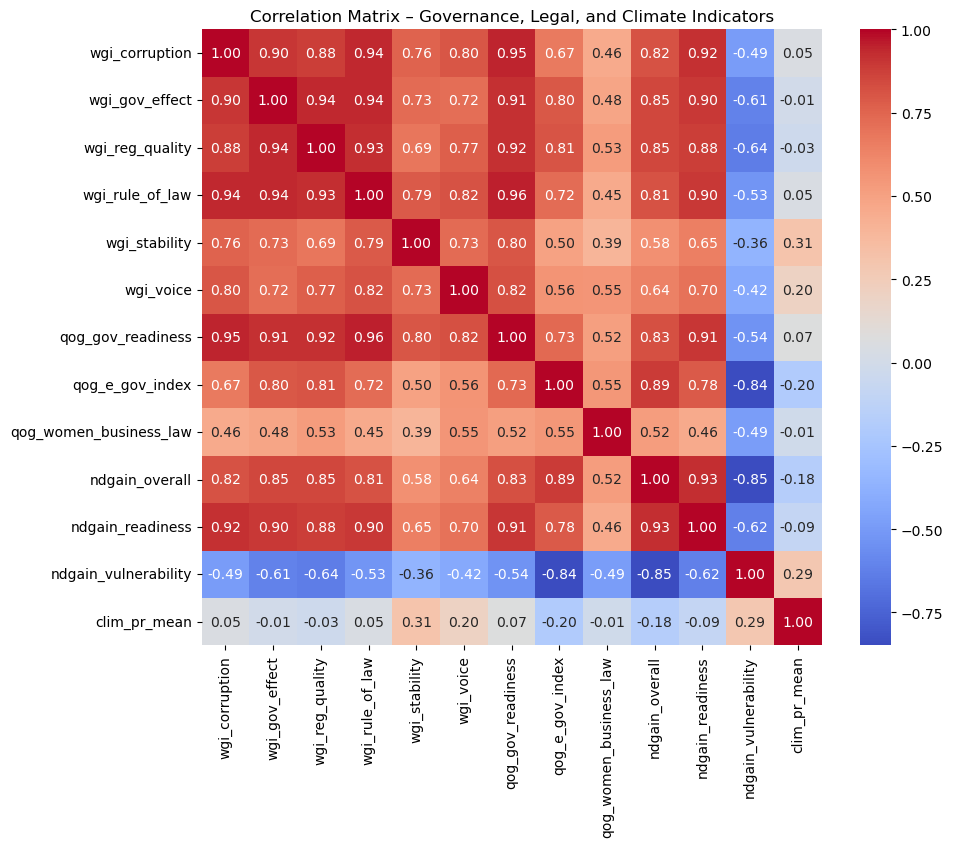

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(df.drop(columns=['country']).corr(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Correlation Matrix – Governance, Legal, and Climate Indicators")
plt.show()


### This interactive scatter plot helps visualize the relationship between climate readiness and vulnerability. We color the dots by `wgi_rule_of_law`.

Ideally, we want to see countries in the **bottom-right** quadrant (high readiness, low vulnerability), which are likely to be those with a high rule of law (darker colors).

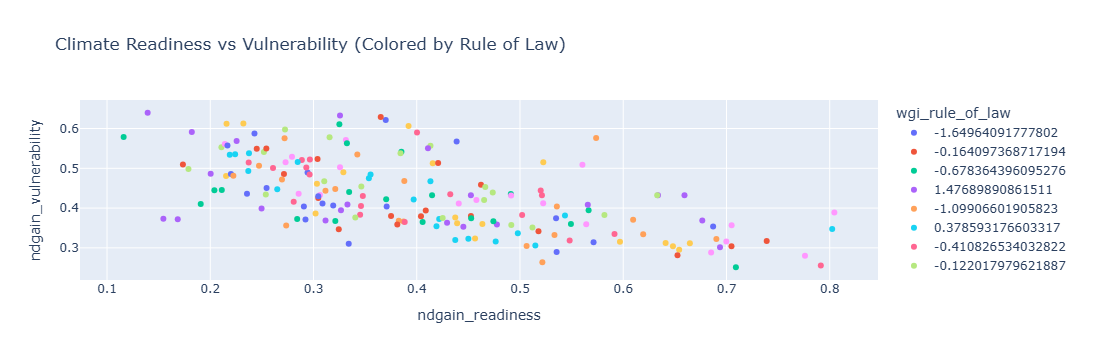

In [36]:
import plotly.express as px

fig = px.scatter(
    df,
    x="ndgain_readiness",
    y="ndgain_vulnerability",
    color="wgi_rule_of_law",
    hover_name="country",
    title="Climate Readiness vs Vulnerability (Colored by Rule of Law)"
)
fig.show()

Let's look at the distributions of the six Worldwide Governance Indicators (WGI) to see if they are normally distributed and to confirm their data types. First, we'll ensure they are all numeric.

In [40]:
gov_cols = ['wgi_corruption','wgi_gov_effect','wgi_reg_quality','wgi_rule_of_law','wgi_stability','wgi_voice']

for col in gov_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(df[gov_cols].dtypes)

wgi_corruption     float64
wgi_gov_effect     float64
wgi_reg_quality    float64
wgi_rule_of_law    float64
wgi_stability      float64
wgi_voice          float64
dtype: object


Now, we'll plot their distributions using a Kernel Density Estimate (KDE) plot. We can see they are all roughly normally distributed around 0, which is expected for these types of indicators.

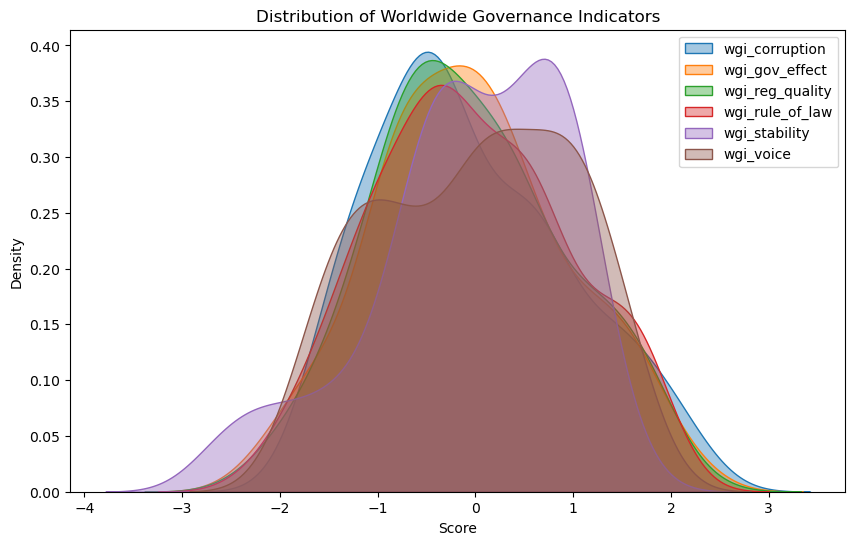

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
for col in gov_cols:
    sns.kdeplot(data=df, x=col, label=col, fill=True, alpha=0.4)
plt.legend()
plt.title("Distribution of Worldwide Governance Indicators")
plt.xlabel("Score")
plt.ylabel("Density")
plt.show()


Here, we explore the relationship between a country's climate (`clim_pr_mean`) and its climate vulnerability (`ndgain_vulnerability`). The dots are colored by political stability.

There doesn't appear to be a simple linear relationship, but we can see that many of the most vulnerable countries (high on y-axis) also tend to have low political stability (lighter/blue dots).

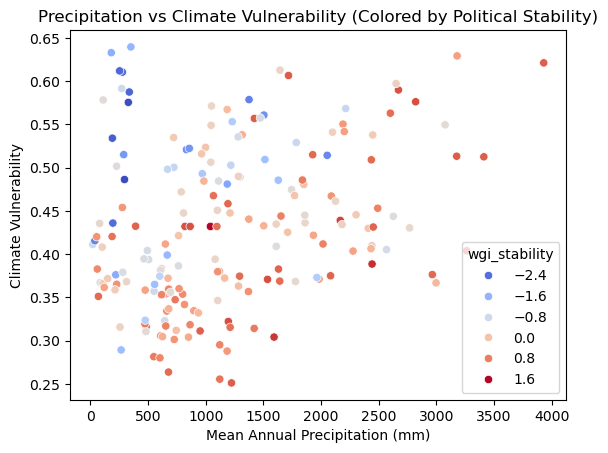

In [42]:
sns.scatterplot(
    data=df,
    x="clim_pr_mean",
    y="ndgain_vulnerability",
    hue="wgi_stability",
    palette="coolwarm"
)
plt.title("Precipitation vs Climate Vulnerability (Colored by Political Stability)")
plt.xlabel("Mean Annual Precipitation (mm)")
plt.ylabel("Climate Vulnerability")
plt.show()

This interactive map shows the baseline 'Global Climate Readiness' score from the ND-GAIN dataset. This is one of our key input variables.

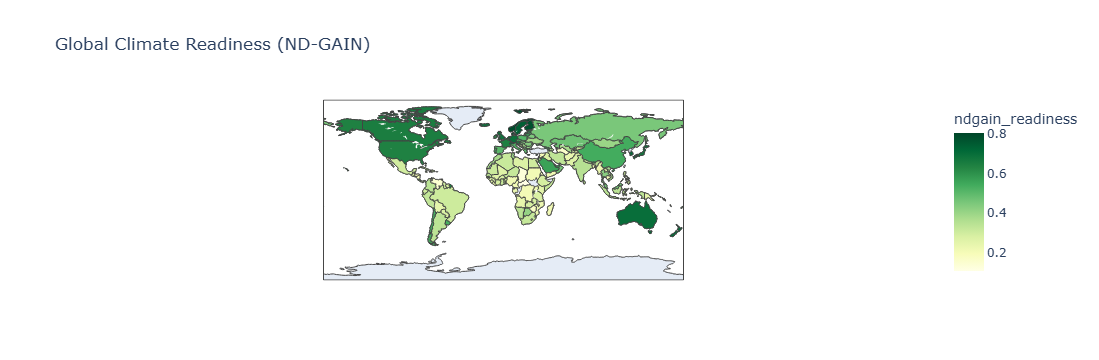

In [43]:
import plotly.express as px

fig = px.choropleth(
    df,
    locations="country",
    locationmode="country names",
    color="ndgain_readiness",
    color_continuous_scale="YlGn",
    title="Global Climate Readiness (ND-GAIN)"
)
fig.show()


This plot checks for a relationship between the 'Women in Business & Law' index and the 'Rule of Law'. As expected, there is a strong positive correlation: countries with stronger rule of law also tend to have more legal protections and economic inclusion for women.

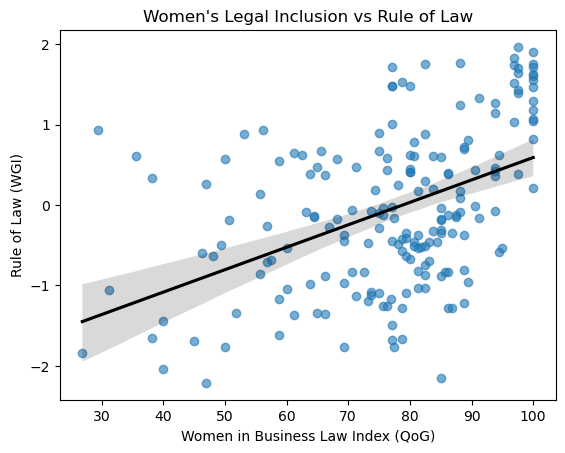

In [44]:
sns.regplot(
    data=df,
    x="qog_women_business_law",
    y="wgi_rule_of_law",
    scatter_kws={'alpha':0.6},
    line_kws={'color':'black'}
)
plt.title("Women's Legal Inclusion vs Rule of Law")
plt.xlabel("Women in Business Law Index (QoG)")
plt.ylabel("Rule of Law (WGI)")
plt.show()

## 3: Modeling & Index Creation
<a id='3-modeling--index-creation'></a>
We will now load the processed `master_countries.csv` file (which we saved at the end of Step 1) and begin modeling.

In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

df = pd.read_csv(r"E:\PROJECTS\climate_legal_readiness_project\data\processed\master_countries.csv")
df.head()

wgi_corruption  wgi_gov_effect  wgi_reg_quality  wgi_rule_of_law  \
0       -1.154932       -1.987014        -1.266425        -1.649641   
1       -0.332219        0.250855         0.171954        -0.164097   
2       -0.589308       -0.670135        -0.948087        -0.678364   
3        1.251356        1.475439         1.350546         1.476899   
4       -0.609920       -1.008910        -0.761388        -1.099066   

   wgi_stability  wgi_voice      country  qog_gov_readiness  qog_e_gov_index  \
0      -2.484081  -1.852901  Afghanistan           0.170507           0.2710   
1       0.183349   0.168997      Albania           0.472414           0.7413   
2      -0.577885  -0.979884      Algeria           0.323543           0.5611   
3       1.583466   0.996940      Andorra           0.492889           0.7177   
4      -0.341505  -0.737252       Angola           0.352678           0.3789   

   qog_women_business_law  ndgain_overall  ndgain_readiness  \
0               38.125000       32.765017          0.242817   
1               91.250000       49.747451          0.375133   
2               57.500000       47.689392          0.321140   
3               77.039835       48.421793          0.452459   
4               79.375000       37.043357          0.247241   

   ndgain_vulnerability  clim_pr_mean  
0              0.587516        336.61  
1              0.380184       1120.21  
2              0.367352         84.22  
3              0.432140       1043.31  
4              0.506373       1043.87

We start by defining the lists of columns that belong to our three conceptual groups: Governance, Legal, and Climate.

First, we'll check that all our columns were loaded correctly.

**Important:** We will create `ndgain_vulnerability_rev` by multiplying `ndgain_vulnerability` by -1. This "reverses" the score, so that for *all* features, a **higher** value is **better** (e.g., higher readiness, lower vulnerability). This step is critical for ensuring our PCA and final index are interpreted correctly.

In [47]:
gov_cols = ['wgi_corruption','wgi_gov_effect','wgi_reg_quality','wgi_rule_of_law','wgi_stability','wgi_voice']
qog_cols = ['qog_gov_readiness','qog_e_gov_index','qog_women_business_law']
clim_cols = ['ndgain_overall','ndgain_readiness','ndgain_vulnerability','clim_pr_mean']

missing = [c for c in (gov_cols+qog_cols+clim_cols) if c not in df.columns]
print("Missing:", missing)

Missing: []


In [48]:
df['ndgain_vulnerability_rev'] = -df['ndgain_vulnerability']

feat_cols = gov_cols + qog_cols + ['ndgain_overall','ndgain_readiness','ndgain_vulnerability_rev','clim_pr_mean']

X = df[feat_cols].copy()
assert X.dtypes.apply(lambda t: np.issubdtype(t, np.number)).all(), "Non-numeric found in features"

### 3.1. Feature Scaling
<a id='31-feature-scaling'></a>
We apply `StandardScaler` to all features. This transforms the data to have a mean of 0 and a standard deviation of 1. This is a mandatory step for PCA and K-Means, as it ensures all features are weighted equally regardless of their original units (e.g., precipitation in mm vs. governance scores from -2.5 to 2.5).

In [49]:
scaler = StandardScaler()
Z = scaler.fit_transform(X)

Z_df = pd.DataFrame(Z, columns=feat_cols)
Z_df.insert(0, 'country', df['country'])
Z_df.head()

country  wgi_corruption  wgi_gov_effect  wgi_reg_quality  \
0  Afghanistan       -1.119724       -1.977435        -1.244751   
1      Albania       -0.291328        0.305533         0.233881   
2      Algeria       -0.550193       -0.634018        -0.917504   
3      Andorra        1.303185        1.554795         1.445457   
4       Angola       -0.570947       -0.979620        -0.725580   

   wgi_rule_of_law  wgi_stability  wgi_voice  qog_gov_readiness  \
0        -1.627590      -2.470359  -1.868382          -1.799745   
1        -0.117053       0.247175   0.177278          -0.114304   
2        -0.639972      -0.528359  -0.985105          -0.945402   
3         1.551552       1.673591   1.014951           0.000000   
4        -1.067752      -0.287538  -0.739622          -0.782752   

   qog_e_gov_index  qog_women_business_law  ndgain_overall  ndgain_readiness  \
0        -1.663432           -2.437321e+00       -1.429039         -1.061986   
1         0.593510            8.900138e-01        0.120997         -0.197146   
2        -0.271259           -1.223823e+00       -0.066848         -0.550053   
3         0.480255            8.900570e-16        0.000000          0.308266   
4        -1.145626            1.462565e-01       -1.038543         -1.033070   

   ndgain_vulnerability_rev  clim_pr_mean  
0             -1.706217e+00     -1.044506  
1              5.705383e-01     -0.101487  
2              7.114506e-01     -1.348244  
3              6.095801e-16     -0.194032  
4             -8.151703e-01     -0.193358

A quick check to confirm our scaler worked: the mean of each column should be ~0 and the standard deviation should be 1.

In [50]:
means = Z_df[feat_cols].mean().round(3)
stds  = Z_df[feat_cols].std(ddof=0).round(3)
print("Means ~ 0?\n", means.head(10))
print("\nStds ~ 1?\n", stds.head(10))

Means ~ 0?
 wgi_corruption           -0.0
wgi_gov_effect           -0.0
wgi_reg_quality           0.0
wgi_rule_of_law           0.0
wgi_stability             0.0
wgi_voice                 0.0
qog_gov_readiness        -0.0
qog_e_gov_index          -0.0
qog_women_business_law    0.0
ndgain_overall            0.0
dtype: float64

Stds ~ 1?
 wgi_corruption            1.0
wgi_gov_effect            1.0
wgi_reg_quality           1.0
wgi_rule_of_law           1.0
wgi_stability             1.0
wgi_voice                 1.0
qog_gov_readiness         1.0
qog_e_gov_index           1.0
qog_women_business_law    1.0
ndgain_overall            1.0
dtype: float64


We'll save this standardized (`Z-score`) dataframe. We will use this file for the final index construction.

In [51]:
out_path = r"E:\PROJECTS\climate_legal_readiness_project\data\processed\master_countries_z.csv"
Z_df.to_csv(out_path, index=False)
print("Saved:", out_path, "shape:", Z_df.shape)

Saved: E:\PROJECTS\climate_legal_readiness_project\data\processed\master_countries_z.csv shape: (190, 14)


### 3.2. Principal Component Analysis (PCA)
<a id='32-principal-component-analysis-pca'></a>
We run PCA on our standardized data to understand the main drivers of variance. This helps validate our feature selection and shows which variables move together. If our features are all measuring a similar underlying concept (i.e., "readiness"), we expect the first principal component (PC1) to explain a very large portion of the variance.

In [53]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

X = Z_df.drop(columns=['country']).values
feature_names = Z_df.drop(columns=['country']).columns
print("Matrix shape:", X.shape)

Matrix shape: (190, 13)


We'll fit the PCA with all components to see how much variance each one explains and how much is explained cumulatively.

In [54]:
pca = PCA(random_state=42)
pca.fit(X)

explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)

# print first few
for i, (var, cum) in enumerate(zip(explained, cum_explained), start=1):
    print(f"PC{i}: {var:.3f}  |  Cumulative: {cum:.3f}")

PC1: 0.698  |  Cumulative: 0.698
PC2: 0.123  |  Cumulative: 0.822
PC3: 0.060  |  Cumulative: 0.882
PC4: 0.040  |  Cumulative: 0.922
PC5: 0.022  |  Cumulative: 0.945
PC6: 0.019  |  Cumulative: 0.963
PC7: 0.014  |  Cumulative: 0.977
PC8: 0.008  |  Cumulative: 0.986
PC9: 0.004  |  Cumulative: 0.990
PC10: 0.004  |  Cumulative: 0.994
PC11: 0.003  |  Cumulative: 0.997
PC12: 0.002  |  Cumulative: 0.999
PC13: 0.001  |  Cumulative: 1.000


The **Scree Plot** helps visualize this. We are looking for the "elbow" point, where the explained variance of subsequent components drops off sharply. We also plot a line at 80% cumulative variance, a common threshold for selecting the number of components.

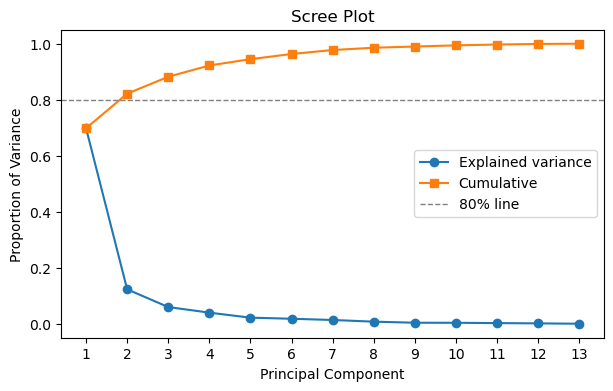

In [55]:
plt.figure(figsize=(7,4))
plt.plot(range(1, len(explained)+1), explained, marker='o', label='Explained variance')
plt.plot(range(1, len(cum_explained)+1), cum_explained, marker='s', label='Cumulative')
plt.axhline(0.8, color='gray', ls='--', lw=1, label='80% line')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance')
plt.xticks(range(1, len(explained)+1))
plt.legend()
plt.show()

The scree plot shows that the first principal component (PC1) explains ~70% of the variance, and the first two components (PC1 + PC2) explain over 80%. This strongly suggests our features are highly correlated and are measuring a single underlying concept.

We will select **k=2** components, as this captures >80% of the variance.

In [56]:
k = np.argmax(cum_explained >= 0.8) + 1
print(f"Number of PCs explaining ≥80% variance: {k}")

Number of PCs explaining ≥80% variance: 2


Now we refit the PCA using only the first two components (k=2) to get the component scores for each country.

In [57]:
pca2 = PCA(n_components=2, random_state=42)
PC = pca2.fit_transform(X)

PC_df = pd.DataFrame(PC, columns=['PC1', 'PC2'])
PC_df.insert(0, 'country', Z_df['country'])
PC_df.head()

country       PC1       PC2
0  Afghanistan -5.703043 -0.857598
1      Albania  0.569711 -0.505184
2      Algeria -1.906000 -1.696770
3      Andorra  2.779288  0.935568
4       Angola -2.700667  0.210375

Let's examine the **loadings** for PC1 and PC2. Loadings show how much each original feature contributes to a principal component.

* **PC1:** All features (except `clim_pr_mean`) have a strong, positive loading. This confirms PC1 is a **"General Readiness"** component. A high PC1 score means a country ranks well across all governance, legal, and climate readiness metrics.
* **PC2:** This component is driven by a contrast between `clim_pr_mean` (climate) and `ndgain_vulnerability`. This can be interpreted as a **"Climate Profile"** component.

In [58]:
loadings = pd.DataFrame(
    pca2.components_.T,
    index=feature_names,
    columns=['PC1', 'PC2']
)
loadings['abs_PC1'] = loadings['PC1'].abs()
loadings['abs_PC2'] = loadings['PC2'].abs()

print("\nTop 8 features driving PC1:")
display(loadings.sort_values('abs_PC1', ascending=False).head(8)[['PC1']])

print("\nTop 8 features driving PC2:")
display(loadings.sort_values('abs_PC2', ascending=False).head(8)[['PC2']])


Top 8 features driving PC1:


PC1
qog_gov_readiness  0.318292
wgi_reg_quality    0.316679
wgi_rule_of_law    0.316150
wgi_gov_effect     0.315560
ndgain_readiness   0.311474
wgi_corruption     0.309929
ndgain_overall     0.306102
qog_e_gov_index    0.281988


Top 8 features driving PC2:


PC2
clim_pr_mean              0.667985
ndgain_vulnerability_rev -0.426528
wgi_stability             0.344431
qog_e_gov_index          -0.288054
wgi_voice                 0.247590
ndgain_overall           -0.222693
wgi_corruption            0.135076
qog_gov_readiness         0.129935

This scatter plot shows all 190 countries in the 2D PCA space. We can see the "General Readiness" (PC1) on the x-axis and the "Climate Profile" (PC2) on the y-axis. This is the data we will use for clustering.

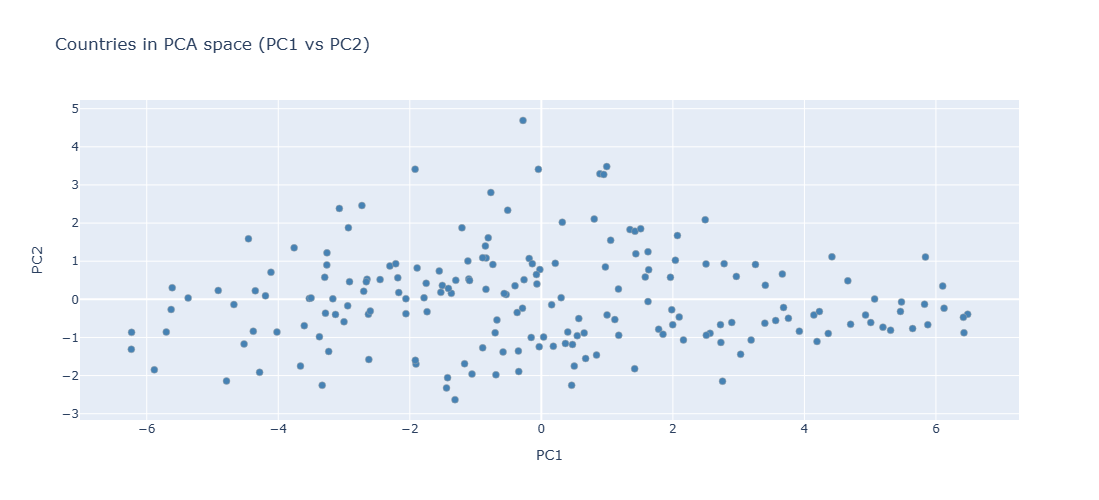

In [59]:
import plotly.express as px

fig = px.scatter(
    PC_df, x='PC1', y='PC2',
    hover_name='country',
    title='Countries in PCA space (PC1 vs PC2)',
    template='plotly',
    width=700, height=500
)
fig.update_traces(marker=dict(size=7, color='steelblue', line=dict(width=0.5, color='darkgray')))
fig.show()

### 3.3. K-Means Clustering
<a id='33-k-means-clustering'></a>
We will use K-Means clustering on the 2D PCA scores (PC1 and PC2) to see if our countries naturally fall into distinct groups.

In [60]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

X_cluster = PC_df[['PC1', 'PC2']].values
print("Shape for clustering:", X_cluster.shape)

Shape for clustering: (190, 2)


We will use the **Elbow Method** (inertia) and **Silhouette Score** to find the optimal number of clusters (k). A good 'k' is where the inertia "elbow" bends and the silhouette score is highest.

*Note: We set `OMP_NUM_THREADS=1` to avoid a known memory leak with KMeans on Windows.*

C:\Users\hrush\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\hrush\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\hrush\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\hrush\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

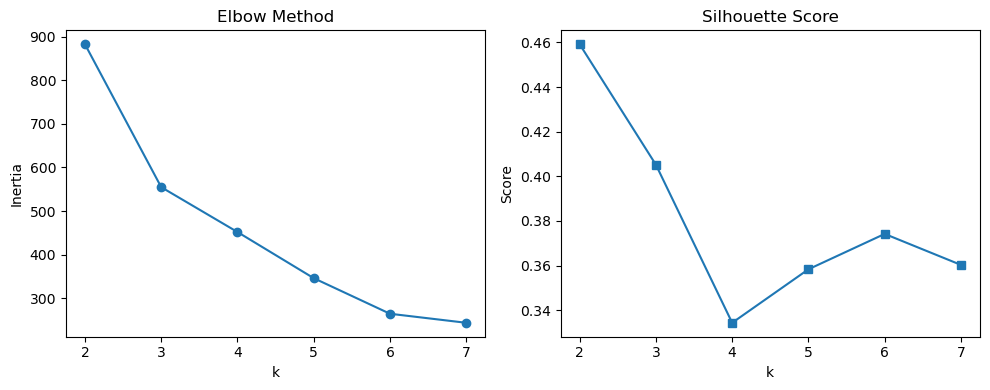

In [62]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

inertias = []
silhouettes = []
K_RANGE = range(2, 8)  

for k in K_RANGE:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(X_cluster)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_cluster, labels))

# Plot both metrics
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(list(K_RANGE), inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('k'); plt.ylabel('Inertia')

plt.subplot(1,2,2)
plt.plot(list(K_RANGE), silhouettes, marker='s')
plt.title('Silhouette Score')
plt.xlabel('k'); plt.ylabel('Score')
plt.tight_layout()
plt.show()

The silhouette score is highest at **k=2**, suggesting a clear two-group split. The elbow plot, however, shows a clear bend at **k=3**.

We will create models for both, but we will ultimately choose **k=3** as it provides a more nuanced "High-Medium-Low" grouping, which is more descriptive for an index.

In [63]:
best_k = list(K_RANGE)[np.argmax(silhouettes)]
print("Best k based on silhouette:", best_k)


Best k based on silhouette: 2


Now we will fit both the `k=2` and `k=3` models and add the resulting cluster labels to our `PC_df` DataFrame for comparison.

In [64]:
from sklearn.cluster import KMeans
import plotly.express as px

k2_model = KMeans(n_clusters=2, random_state=42, n_init='auto')
labels_k2 = k2_model.fit_predict(X_cluster)

k3_model = KMeans(n_clusters=3, random_state=42, n_init='auto')
labels_k3 = k3_model.fit_predict(X_cluster)

PC_df['cluster_k2'] = labels_k2
PC_df['cluster_k3'] = labels_k3
PC_df.head()

C:\Users\hrush\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\hrush\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



country       PC1       PC2  cluster_k2  cluster_k3
0  Afghanistan -5.703043 -0.857598           0           0
1      Albania  0.569711 -0.505184           1           2
2      Algeria -1.906000 -1.696770           0           0
3      Andorra  2.779288  0.935568           1           1
4       Angola -2.700667  0.210375           0           0

Plotting the clusters shows the difference:
* **k=2:** Splits countries into one large "low/medium" group (PC1 < 2) and a smaller "high" group (PC1 > 2).
* **k=3:** Gives us a "low" (PC1 < -1.5), "medium" (PC1 between -1.5 and 2.5), and "high" (PC1 > 2.5) group. This is the split we will use for our analysis.

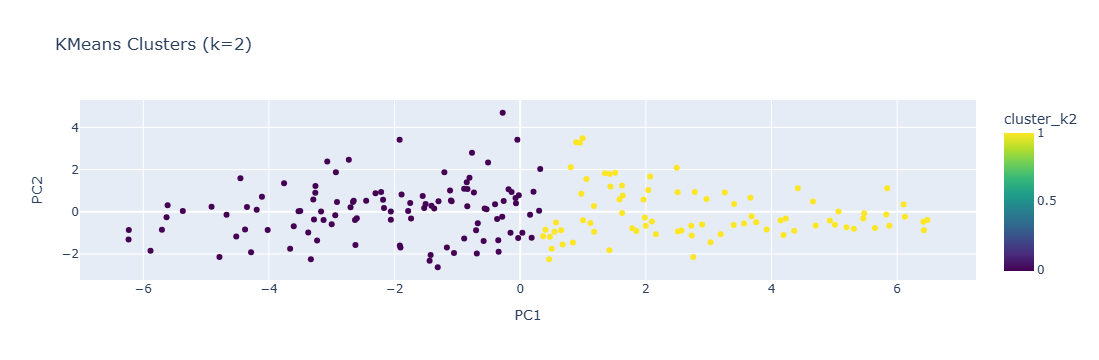

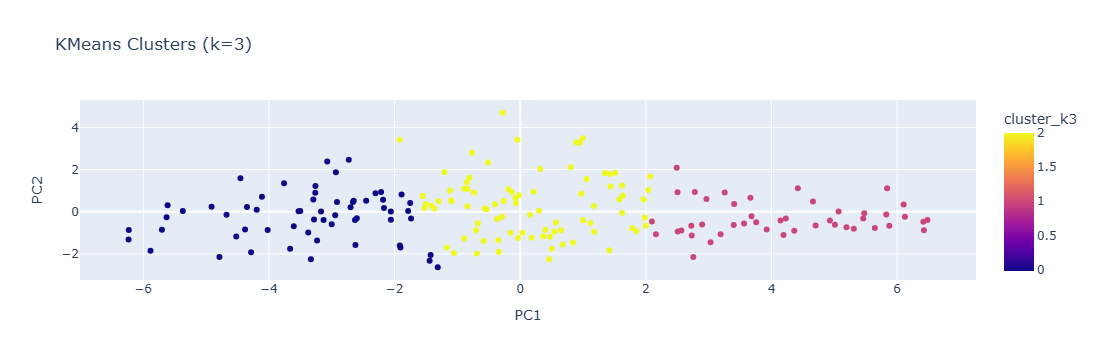

In [65]:
# K=2
fig2 = px.scatter(
    PC_df, x='PC1', y='PC2', color='cluster_k2',
    hover_name='country', title='KMeans Clusters (k=2)',
    color_continuous_scale='Viridis', template='plotly'
)
fig2.show()

# K=3
fig3 = px.scatter(
    PC_df, x='PC1', y='PC2', color='cluster_k3',
    hover_name='country', title='KMeans Clusters (k=3)',
    color_continuous_scale='Plasma', template='plotly'
)
fig3.show()

Looking at the centroids (the average PC1/PC2 score for each cluster) confirms our interpretation of the k=3 groups.
* **Cluster 0:** Low PC1 score (-3.35)
* **Cluster 2:** Medium PC1 score (0.15)
* **Cluster 1:** High PC1 score (4.18)

In [66]:
summary_k2 = PC_df.groupby('cluster_k2')[['PC1','PC2']].mean().round(2)
summary_k3 = PC_df.groupby('cluster_k3')[['PC1','PC2']].mean().round(2)

print("Cluster centroids (k=2):\n", summary_k2)
print("\nCluster centroids (k=3):\n", summary_k3)

Cluster centroids (k=2):
              PC1   PC2
cluster_k2            
0          -2.12  0.05
1           2.85 -0.06

Cluster centroids (k=3):
              PC1   PC2
cluster_k3            
0          -3.35 -0.23
1           4.18 -0.30
2           0.15  0.32


## 4: Final Index Construction
<a id='4-final-index-construction'></a>

We will now construct the final Climate Legal Readiness Index (CLRI).

### 4.1: Method 1 - Equal-Weight Index (Z-Score)
<a id='41-method-1-equal-weight-index-z-score'></a>
This is our primary method. We will re-load our standardized `Z_df` file and merge our chosen `cluster_k3` labels from the previous step.

In [67]:
import pandas as pd

Z_df = pd.read_csv(
    r"E:\PROJECTS\climate_legal_readiness_project\data\processed\master_countries_z.csv"
)
Z_df = Z_df.merge(PC_df[['country', 'cluster_k3']], on='country', how='left')
Z_df.head()

country  wgi_corruption  wgi_gov_effect  wgi_reg_quality  \
0  Afghanistan       -1.119724       -1.977435        -1.244751   
1      Albania       -0.291328        0.305533         0.233881   
2      Algeria       -0.550193       -0.634018        -0.917504   
3      Andorra        1.303185        1.554795         1.445457   
4       Angola       -0.570947       -0.979620        -0.725580   

   wgi_rule_of_law  wgi_stability  wgi_voice  qog_gov_readiness  \
0        -1.627590      -2.470359  -1.868382          -1.799745   
1        -0.117053       0.247175   0.177278          -0.114304   
2        -0.639972      -0.528359  -0.985105          -0.945402   
3         1.551552       1.673591   1.014951           0.000000   
4        -1.067752      -0.287538  -0.739622          -0.782752   

   qog_e_gov_index  qog_women_business_law  ndgain_overall  ndgain_readiness  \
0        -1.663432           -2.437321e+00       -1.429039         -1.061986   
1         0.593510            8.900138e-01        0.120997         -0.197146   
2        -0.271259           -1.223823e+00       -0.066848         -0.550053   
3         0.480255            8.900570e-16        0.000000          0.308266   
4        -1.145626            1.462565e-01       -1.038543         -1.033070   

   ndgain_vulnerability_rev  clim_pr_mean  cluster_k3  
0             -1.706217e+00     -1.044506           0  
1              5.705383e-01     -0.101487           2  
2              7.114506e-01     -1.348244           0  
3              6.095801e-16     -0.194032           1  
4             -8.151703e-01     -0.193358           0

We will create three sub-indices (Governance, Legal, Climate) by averaging the z-scores of their constituent features. The final CLRI will be the average of these three sub-indices.

In [68]:
gov_cols = ['wgi_corruption','wgi_gov_effect','wgi_reg_quality',
            'wgi_rule_of_law','wgi_stability','wgi_voice']

qog_cols = ['qog_gov_readiness','qog_e_gov_index','qog_women_business_law']

clim_cols = ['ndgain_overall','ndgain_readiness',
             'ndgain_vulnerability_rev','clim_pr_mean']

Z_df['sub_governance'] = Z_df[gov_cols].mean(axis=1)
Z_df['sub_legal']      = Z_df[qog_cols].mean(axis=1)
Z_df['sub_climate']    = Z_df[clim_cols].mean(axis=1)

Z_df[['sub_governance','sub_legal','sub_climate']].describe().round(2)

sub_governance  sub_legal  sub_climate
count          190.00     190.00       190.00
mean             0.00       0.00         0.00
std              0.93       0.86         0.69
min             -1.99      -2.29        -1.80
25%             -0.68      -0.53        -0.51
50%             -0.05      -0.06        -0.06
75%              0.65       0.55         0.40
max              1.85       1.73         1.74

The final `CLRI` is the mean of the three sub-indices. We also create a `CLRI_rank` column to easily see the top and bottom performers.

In [72]:
Z_df['CLRI'] = Z_df[['sub_governance','sub_legal','sub_climate']].mean(axis=1)
Z_df['CLRI_rank'] = Z_df['CLRI'].rank(ascending=False, method='dense').astype(int)

top5 = Z_df.sort_values('CLRI', ascending=False).head(5)
bottom5 = Z_df.sort_values('CLRI', ascending=True).head(5)

print("Top 5 countries:")
display(top5[['country','CLRI','CLRI_rank','cluster_k3']])

print("\nBottom 5 countries:")
display(bottom5[['country','CLRI','CLRI_rank','cluster_k3']])

Top 5 countries:


country      CLRI  CLRI_rank  cluster_k3
127       Norway  1.659877          1           1
122  New Zealand  1.624708          2           1
45       Denmark  1.623536          3           1
58       Finland  1.614856          4           1
150    Singapore  1.559533          5           1


Bottom 5 countries:


country      CLRI  CLRI_rank  cluster_k3
187        Yemen -1.816268        190           0
154      Somalia -1.775871        189           0
0    Afghanistan -1.665103        188           0
165        Syria -1.635812        187           0
53       Eritrea -1.535121        186           0

Now, we can check the average sub-index and CLRI scores for each of our k=3 clusters. This validates our clustering:
* **Cluster 1:** High CLRI (avg 1.07)
* **Cluster 2:** Medium CLRI (avg 0.05)
* **Cluster 0:** Low CLRI (avg -0.87)

In [73]:
cluster_summary = (
    Z_df.groupby('cluster_k3')[['sub_governance','sub_legal','sub_climate','CLRI']]
        .mean().round(2)
)
cluster_summary

sub_governance  sub_legal  sub_climate  CLRI
cluster_k3                                              
0                    -1.03      -0.89        -0.70 -0.87
1                     1.20       1.13         0.87  1.07
2                     0.09       0.03         0.03  0.05

We save this dataframe, which contains the final Z-Score CLRI, sub-indices, and cluster labels.

In [74]:
out_path = r"E:\PROJECTS\climate_legal_readiness_project\data\processed\countries_clri_zscore.csv"
Z_df.to_csv(out_path, index=False)
print("Saved:", out_path, "shape:", Z_df.shape)

Saved: E:\PROJECTS\climate_legal_readiness_project\data\processed\countries_clri_zscore.csv shape: (190, 20)


### 4.2: Method 2 - PCA-Weighted Index (Validation)
<a id='42-method-2-pca-weighted-index-validation'></a>
As a validation step, we create an alternative index. Instead of equal weights (Method 1), we use the variance explained by the first two principal components as weights. This creates an index that is more heavily weighted towards the features that contribute to PC1 (~85% weight).

We re-run the PCA on the same features as before.

In [75]:
from sklearn.decomposition import PCA
import numpy as np

X = Z_df.drop(columns=['country','cluster_k3','sub_governance','sub_legal','sub_climate','CLRI','CLRI_rank'], errors='ignore')
feature_names = X.columns

pca = PCA(n_components=2, random_state=42)
PC = pca.fit_transform(X)
PC_weighted = pd.DataFrame(PC, columns=['PC1','PC2'])
PC_weighted.insert(0,'country', Z_df['country'])
PC_weighted.head()

country       PC1       PC2
0  Afghanistan -5.703043 -0.857598
1      Albania  0.569711 -0.505184
2      Algeria -1.906000 -1.696770
3      Andorra  2.779288  0.935568
4       Angola -2.700667  0.210375

We use the `explained_variance_ratio_` as the weights for PC1 and PC2.

**Important:** We check the correlation between our new PC scores and our original `CLRI` (Z-Score method). If `PC1` is negatively correlated (which it is), we flip its sign (`*= -1`). This is a crucial step to ensure that a *high* PC1 score aligns with a *high* CLRI score, making the two methods comparable.

Finally, we calculate the weighted sum and then scale *that* final score to a z-score (`CLRI_PCA_z`) so it's on the same scale as our first index.

In [76]:
weights = pca.explained_variance_ratio_ / pca.explained_variance_ratio_.sum()
print("PCA weights:", weights)

corr_pc1 = np.corrcoef(PC_weighted['PC1'], Z_df['CLRI'])[0,1]
corr_pc2 = np.corrcoef(PC_weighted['PC2'], Z_df['CLRI'])[0,1]

if corr_pc1 < 0:
    PC_weighted['PC1'] *= -1
if corr_pc2 < 0:
    PC_weighted['PC2'] *= -1

PC_weighted['CLRI_PCA'] = (weights[0]*PC_weighted['PC1'] + weights[1]*PC_weighted['PC2'])
PC_weighted['CLRI_PCA_z'] = (PC_weighted['CLRI_PCA'] - PC_weighted['CLRI_PCA'].mean()) / PC_weighted['CLRI_PCA'].std()
PC_weighted['CLRI_PCA_rank'] = PC_weighted['CLRI_PCA_z'].rank(ascending=False, method='dense').astype(int)
PC_weighted.sort_values('CLRI_PCA_z', ascending=False).head(10)

PCA weights: [0.84974443 0.15025557]


country       PC1       PC2  CLRI_PCA  CLRI_PCA_z  CLRI_PCA_rank
45       Denmark  6.482313 -0.390519  5.449631    2.117115              1
127       Norway  6.416973 -0.472111  5.381850    2.090783              2
58       Finland  6.426314 -0.876911  5.328964    2.070238              3
122  New Zealand  6.102705  0.347826  5.238003    2.034900              4
164  Switzerland  6.123546 -0.232078  5.168578    2.007930              5
150    Singapore  5.840348  1.109897  5.129572    1.992776              6
99    Luxembourg  5.826470 -0.127682  4.931826    1.915954              7
163       Sweden  5.876223 -0.665689  4.893264    1.900974              8
8      Australia  5.645309 -0.767328  4.681775    1.818812              9
74       Iceland  5.476044 -0.067141  4.643150    1.803807             10

Finally, we merge this new PCA-weighted index and its rank back into our main `Z_df` and save the result as our single, final output file.

In [77]:
Z_df = Z_df.merge(PC_weighted[['country','CLRI_PCA_z','CLRI_PCA_rank']], on='country', how='left')
Z_df.to_csv(r"E:\PROJECTS\climate_legal_readiness_project\data\processed\countries_clri_combined.csv", index=False)
print("Merged PCA-weighted index; new shape:", Z_df.shape)

Merged PCA-weighted index; new shape: (190, 22)


This is our key validation step. We check the Pearson correlation between our Z-Score CLRI (Method 1) and our PCA-Weighted CLRI (Method 2).

In [78]:
Z_df[['CLRI','CLRI_PCA_z']].corr()

CLRI  CLRI_PCA_z
CLRI        1.000000    0.991675
CLRI_PCA_z  0.991675    1.000000

A correlation of **0.99** shows that both methods (equal-weight and PCA-weighted) produce nearly identical results. This gives us high confidence in our primary (and more interpretable) equal-weight `CLRI`.

This scatter plot confirms it. The points form a tight line along the 45-degree angle, showing the two methods are interchangeable. The k=3 clusters also align perfectly.

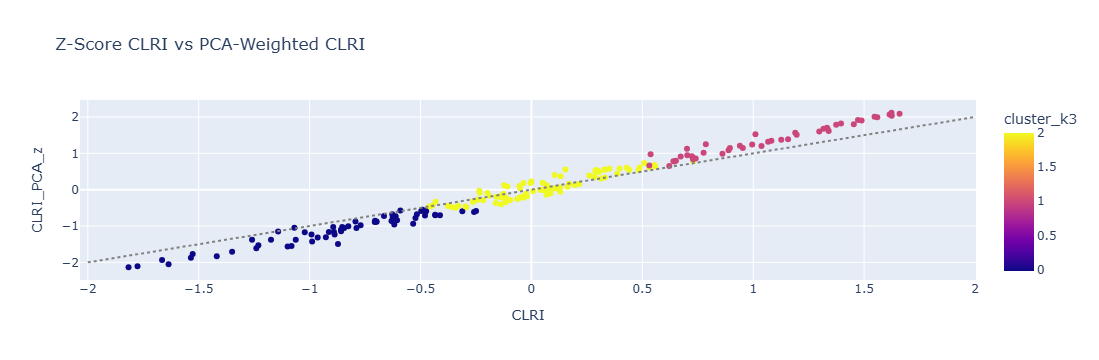

In [79]:
import plotly.express as px

fig = px.scatter(Z_df,
                 x='CLRI', y='CLRI_PCA_z',
                 hover_name='country',
                 color='cluster_k3',
                 title='Z-Score CLRI vs PCA-Weighted CLRI',
                 template='plotly')
fig.add_shape(type='line', x0=-2, y0=-2, x1=2, y1=2,
              line=dict(color='gray', dash='dot'))
fig.show()


## 5: Final Visualization & Export
<a id='5-final-visualization--export'></a>
Finally, we plot our two CLRI versions on global choropleth maps. The `Viridis` map shows our primary Z-Score index, and the `Plasma` map shows the PCA-weighted validation index. As expected from the 0.99 correlation, the maps are nearly identical.

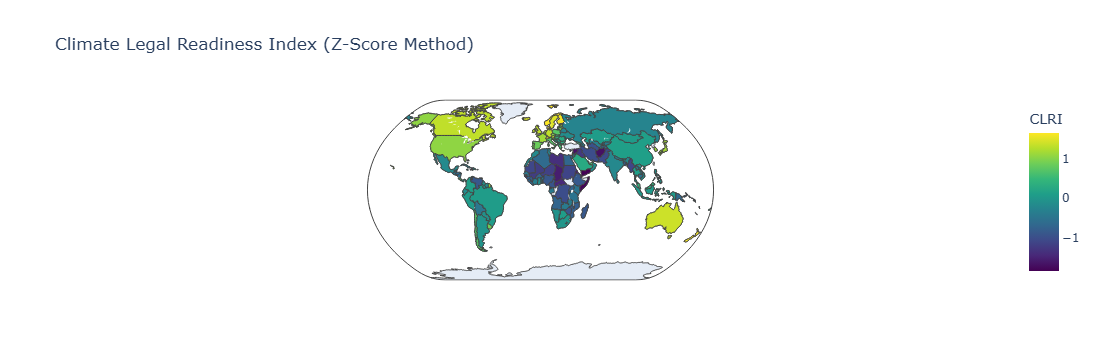

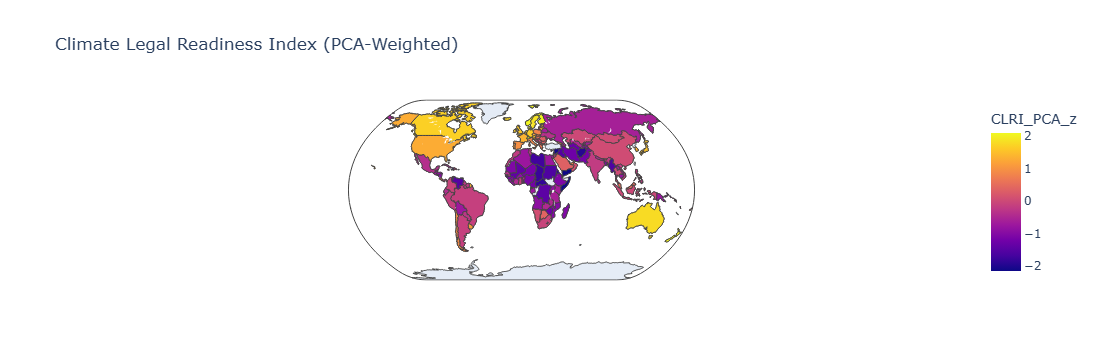

In [80]:
fig = px.choropleth(
    Z_df,
    locations='country',
    locationmode='country names',
    color='CLRI',
    color_continuous_scale='Viridis',
    title='Climate Legal Readiness Index (Z-Score Method)',
    projection='natural earth'
)
fig.show()

fig2 = px.choropleth(
    Z_df,
    locations='country',
    locationmode='country names',
    color='CLRI_PCA_z',
    color_continuous_scale='Plasma',
    title='Climate Legal Readiness Index (PCA-Weighted)',
    projection='natural earth'
)
fig2.show()


In [84]:
import os

output_dir = r"E:\PROJECTS\climate_legal_readiness_project\outputs"
os.makedirs(output_dir, exist_ok=True)

fig.write_html(os.path.join(output_dir, "CLRI_Zscore_Map.html"))
fig2.write_html(os.path.join(output_dir, "CLRI_PCA_Map.html"))
print("Saved both map files to:", output_dir)

Saved both map files to: E:\PROJECTS\climate_legal_readiness_project\outputs
